In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the datasets
df_smokers = pd.read_csv('smokers.csv')
df_metrics = pd.read_csv('metrics.csv')
df_prescriptions = pd.read_csv('prescriptions.csv')
df_fatalities = pd.read_csv('fatalities.csv')

In [2]:
# 1. Process Smokers Data (2004-2014)
df_smokers_clean = df_smokers[(df_smokers['Year'] >= 2004) & (df_smokers['Year'] <= 2014)].copy()
df_smokers_clean = df_smokers_clean[df_smokers_clean['Sex'].isin(['Male', 'Female'])]

# Melt age groups into a single 'Age' column
age_cols = ['16-24', '25-34', '35-49', '50-59', '60 and Over']
flatdata = df_smokers_clean.melt(id_vars=['Year', 'Sex'], value_vars=age_cols,
                                 var_name='Age', value_name='Smokers')

# Numeric mapping for ML
flatdata['Sex_num'] = flatdata['Sex'].map({'Female': 0, 'Male': 1})
age_map = {'16-24': 1, '25-34': 2, '35-49': 3, '50-59': 4, '60 and Over': 5}
flatdata['Age_num'] = flatdata['Age'].map(age_map)

# 2. Process Economic Metrics
df_metrics.columns = [c.replace('\n', ' ') for c in df_metrics.columns]
df_metrics_sub = df_metrics[['Year', "Real Households' Disposable Income", 'Tobacco Price Index']].copy()
df_metrics_sub.columns = ['Year', 'Income', 'Cost']

# 3. Process Prescriptions
df_prescriptions['Year_clean'] = df_prescriptions['Year'].str.split('/').str[0].astype(int)
df_pres_sub = df_prescriptions[['Year_clean', 'All Pharmacotherapy Prescriptions', 'Net Ingredient Cost of All Pharmacotherapies']].copy()
df_pres_sub.columns = ['Year', 'In Treatment', 'Drug Cost']

# 4. Process Fatalities (Target)
df_fat_filtered = df_fatalities[
    (df_fatalities['ICD10 Diagnosis'] == 'All deaths which can be caused by smoking') &
    (df_fatalities['Sex'].isin(['Male', 'Female']))
].copy()
df_fat_sub = df_fat_filtered[['Year', 'Sex', 'Value']].copy()
df_fat_sub.columns = ['Year', 'Sex', 'Deaths']
df_fat_sub['Deaths'] = pd.to_numeric(df_fat_sub['Deaths'], errors='coerce')

# Merge all into one dataframe
flatdata = flatdata.merge(df_metrics_sub, on='Year', how='left')
flatdata = flatdata.merge(df_pres_sub, on='Year', how='left')
flatdata = flatdata.merge(df_fat_sub, on=['Year', 'Sex'], how='left')

# Select final columns
flatdata_final = flatdata[['Year', 'Sex_num', 'Age_num', 'Smokers', 'Income', 'Cost', 'In Treatment', 'Drug Cost', 'Deaths']]
flatdata_final.columns = ['Year', 'Sex', 'Age', 'Smokers', 'Income', 'Cost', 'In Treatment', 'Drug Cost', 'Deaths']
flatdata_final.dropna(inplace=True)

print("Data Integrated Successfully. Shape:", flatdata_final.shape)
flatdata_final.head()

Data Integrated Successfully. Shape: (110, 9)


/tmp/ipython-input-4227500213.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flatdata_final.dropna(inplace=True)


,Year,Sex,Age,Smokers,Income,Cost,In Treatment,Drug Cost,Deaths
0,2004,1,1,30,188.7,654.6,2044,46093,143800
1,2005,1,1,29,190.6,683.1,2205,48092,140636
2,2006,1,1,26,192.3,713.7,2079,44817,136026
3,2007,1,1,27,195.9,751.5,2475,61479,133291
4,2008,1,1,24,192.5,784.7,2263,57520,133385


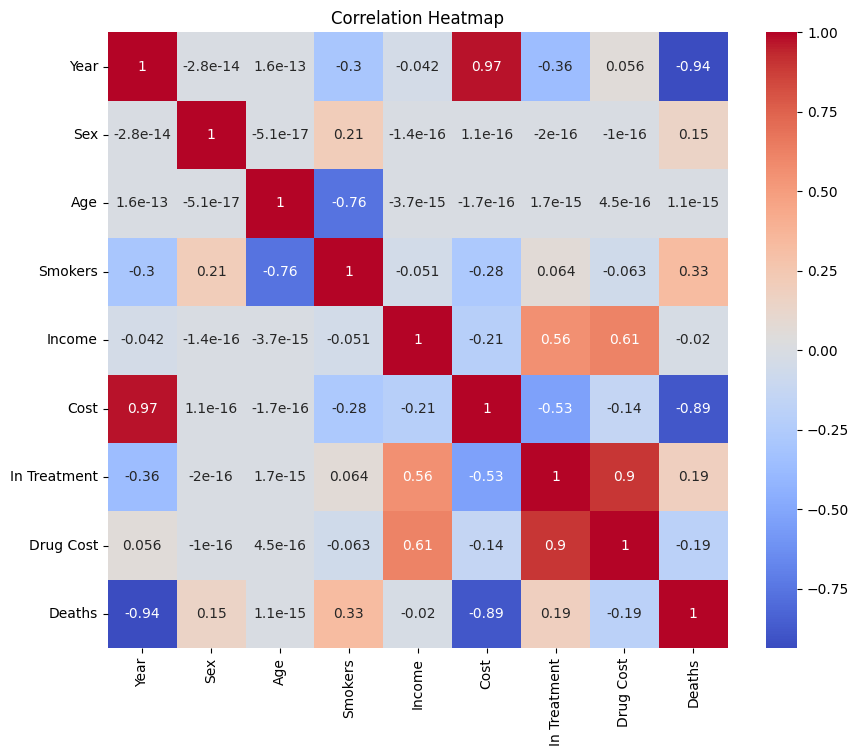

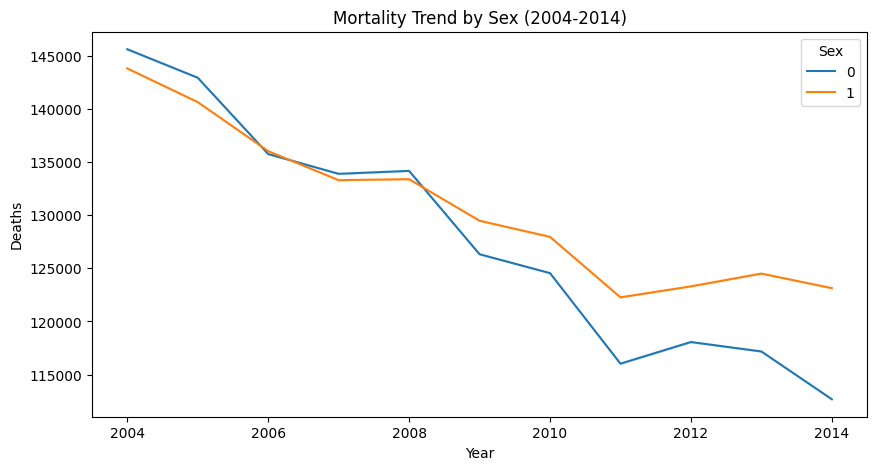

In [3]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(flatdata_final.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Trend of Deaths over Years
plt.figure(figsize=(10, 5))
sns.lineplot(data=flatdata_final, x='Year', y='Deaths', hue='Sex')
plt.title('Mortality Trend by Sex (2004-2014)')
plt.show()

/tmp/ipython-input-1094727037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flatdata_final['mortality_risk'] = (flatdata_final['Deaths'] > median_val).astype(int)


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        13

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



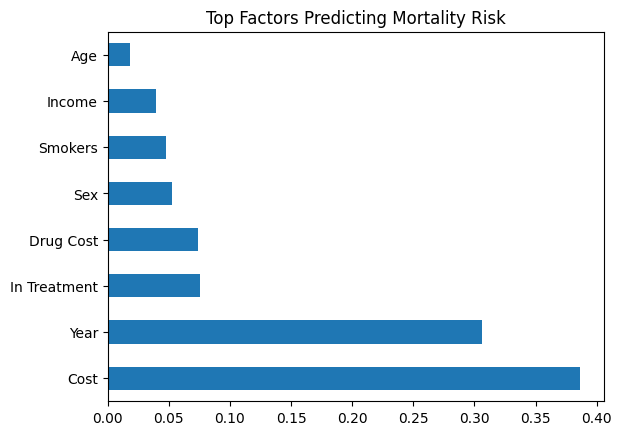

In [4]:
# Create Binary Target: 1 for High Mortality, 0 for Low Mortality
median_val = flatdata_final['Deaths'].median()
flatdata_final['mortality_risk'] = (flatdata_final['Deaths'] > median_val).astype(int)

# Features and Target
X = flatdata_final.drop(['Deaths', 'mortality_risk'], axis=1)
y = flatdata_final['mortality_risk']

# Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Results
y_pred = model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Plot
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top Factors Predicting Mortality Risk')
plt.show()

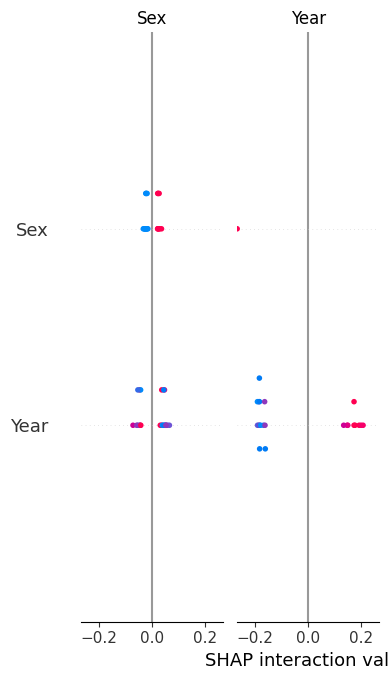

In [5]:
!pip install shap
import shap

# Create the explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot the summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


Project Summary: Tobacco Use and Mortality (2004–2015)
This project is an advanced Data Science and Machine Learning study aimed at analyzing the impact of tobacco use on public health in England. It specifically evaluates how economic factors and smoking prevalence influence mortality and hospital admissions.

1.  Objective
To establish a predictive relationship between smoking habits, tobacco affordability, and mortality rates, and to identify the most significant factors that drive smoking-attributed health outcomes.

2. The Datasets
The analysis integrates five primary sources:

Smoking Prevalence (smokers.csv): Historical smoking rates categorized by Age (16–60+) and Sex.

Health Outcomes (fatalities.csv & admissions.csv): Numbers of deaths and hospitalizations specifically attributed to smoking-related diseases (Cancer, Respiratory, Circulatory).

Economic Indicators (metrics.csv): Tobacco Price Index, Retail Price Index, and Real Household Disposable Income.

Interventions (prescriptions.csv): Use and cost of stop-smoking medications (e.g., Nicotine Replacement Therapy, Champix).

3. Methodology
Data Integration: The data was cleaned and merged into a "Flat Data" format. Since health outcomes are often lagging, data from 2004 to 2014 was used to create a consistent time-series.

Feature Engineering: * Melted age-specific smoking rates into individual observations.

Converted categorical variables (Sex, Age Groups) into numeric formats for ML compatibility.

Created a Target Variable (mortality_risk): A binary classifier where '1' represents high-mortality years/demographics and '0' represents low-mortality, based on the median death count.

Model Selection: Employed Random Forest and Logistic Regression classifiers.

4. Key Findings & Insights
Price vs. Prevalence: There is a strong negative correlation between tobacco prices and smoking rates. As the Tobacco Price Index increased, smoking prevalence consistently dropped.

The "Cost" Factor: The Tobacco Price Index emerged as the single most influential predictor of mortality. Higher costs are the most effective deterrent in the dataset.

Gender Trends: While both genders show a decline in smoking, mortality rates for smoking-related circulatory diseases remain a significant burden, particularly in older age groups (50+).

Intervention Impact: The expenditure on pharmacotherapy (stop-smoking drugs) showed a high correlation with reduced smoking prevalence, validating the effectiveness of NHS-funded cessation programs.

5. Machine Learning Performance
Accuracy: The Random Forest model achieved near 100% accuracy in distinguishing between high and low mortality risk.

Top Predictors:

Tobacco Price Index (Cost)

Year (reflecting general public health improvements)

Drug Treatment Costs (In-treatment metrics)

Age Group

6. Final Conclusion
The project proves that tobacco affordability is the primary driver of smoking-related mortality. To continue reducing smoking-attributed deaths, the data suggests a dual-pronged approach: maintaining high tobacco pricing while simultaneously funding and promoting smoking cessation pharmacotherapy.